# OpMet Challenge 2021: Falkland Rotors - Hyperparameter Tuning in sklearn

Following on from the previous basic ML using scikit-learn notebook, we now proceed to using hyperparameter tuning to select the best hyperparameters for our three model types from sklearn (decision tree, random forest and neural network).

### Import packages

In this notebook, in addition to the standard python auxillary libraries, we are using the following:
* matplotlib - plotting 
* pandas - loading tabular data
* scikit learn - machine learning

This has been tested with the conda environment based on the requirements.yaml file in this repository, as well as the `scitools/experimental-current` Met Office managed conda environement (August 20201).

In [1]:
import pathlib
import os
import datetime
import math
import functools
import numpy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas

In [4]:
import iris

In [5]:
import matplotlib

In [6]:
%matplotlib inline

In [7]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.neural_network
import sklearn.metrics

In [8]:
import opmet_metrics

In [9]:
try:
    root_data_dir = os.environ['OPMET_DATA_ROOT']
except KeyError:
    root_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
root_data_dir

'/Users/stephen.haddad/data/ml_challenges/'

## Exploring Falklands Rotor Data

In [10]:
falklands_dir = 'Rotors'
falklands_data_path = pathlib.Path(root_data_dir, falklands_dir)

In [11]:
falklands_new_training_data_path = pathlib.Path(falklands_data_path, 'new_training.csv')

In [12]:
falklands_training_df = pandas.read_csv(falklands_new_training_data_path, header=0).loc[1:,:]
falklands_training_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [13]:
falklands_training_df = falklands_training_df.drop_duplicates(subset='DTG')

In [14]:
falklands_training_df.shape

(17507, 95)

### Specify and create input features

In [15]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'

In [16]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [17]:
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_training_df[u_feature_template.format(level_ix=level_ix)] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_training_df[v_feature_template.format(level_ix=level_ix)] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [18]:
falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
falklands_training_df.loc[falklands_training_df[falklands_training_df['Rotors 1 is true'].isna()].index, target_feature_name] = 0.0
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

In [19]:
falklands_training_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors_present, dtype: int64

In [20]:
falklands_training_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'v_wind_18', 'u_wind_19', 'v_wind_19', 'u_wind_20', 'v_wind_20',
       'u_wind_21', 'v_wind_21', 'u_wind_22', 'v_wind_22', 'rotors_present'],
      dtype='object', length=140)

### Split into traing/validate/test sets

In [21]:
test_set_name = 'test_set'

In [22]:
test_fraction = 0.1
validation_fraction = 0.1

In [23]:
num_no_rotors = sum(falklands_training_df[target_feature_name] == False)
num_with_rotors = sum(falklands_training_df[target_feature_name] == True)

In [24]:
data_no_rotors = falklands_training_df[falklands_training_df[target_feature_name] == False]
data_with_rotors = falklands_training_df[falklands_training_df[target_feature_name] == True]

In [25]:
data_test = pandas.concat([data_no_rotors.sample(int(test_fraction * num_no_rotors)), data_with_rotors.sample(int(test_fraction * num_with_rotors))])
data_test[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [26]:
falklands_training_df[test_set_name] = False
falklands_training_df.loc[data_test.index,test_set_name] = True

In [27]:
data_working = falklands_training_df[falklands_training_df[test_set_name] == False]
data_working_no_rotors = data_working[data_working[target_feature_name] == False]
data_working_with_rotors = data_working[data_working[target_feature_name] == True]

# Preprocess data into input for ML algorithm

In [28]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [29]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_working[[if1]])
    preproc_dict[if1] = scaler1

In [30]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(data_working[[target_feature_name]])

LabelEncoder()

Apply transformation to each input column

In [31]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [32]:
X_working = preproc_input(data_working, preproc_dict)
y_working = preproc_target(data_working, target_encoder)

create target feature from rotors

In [33]:
y_working.shape, X_working.shape

((15758,), (15758, 88))

In [34]:
X_test = preproc_input(data_test, preproc_dict)
y_test = preproc_target(data_test, target_encoder)

In [35]:
train_test_dict = {
    'train':     (X_working, y_working),
    'test': (X_test, y_test),
}
train_val_test_tuples = list(train_test_dict.values())

### train some classifiers

In [36]:
# nn_hidden_layers_specs = [(50,)*2, (50,)*4, (50,)*8, (100,)*2, (100,)*5, (100,)*8, (200,)*4, (400,)*4, (500,)*4]
nn_hidden_layers_specs = [(50,)*2, (50,)*8, (100,)*2, (100,)*5,]

classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':[5,10,15,20], 'class_weight':['balanced']}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':[5,10,15,20], 'class_weight':['balanced']}},
     'ann': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes': nn_hidden_layers_specs}},   
}



In [37]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class']()
    cv1 = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
    hpt1 = sklearn.model_selection.GridSearchCV(clf1, 
                                                clf_params['opts'],
                                                cv=cv1,
                                               )
    res1 = hpt1.fit(X_working, y_working)
    classifiers_dict[clf_name] = hpt1

decision_tree
random_forest
ann
CPU times: user 15min 1s, sys: 7.19 s, total: 15min 8s
Wall time: 5min 3s


In [38]:
metrics, metrics_df_list = opmet_metrics.calculate_metric_suite(
    classifiers_dict, 
    train_test_dict,
)

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

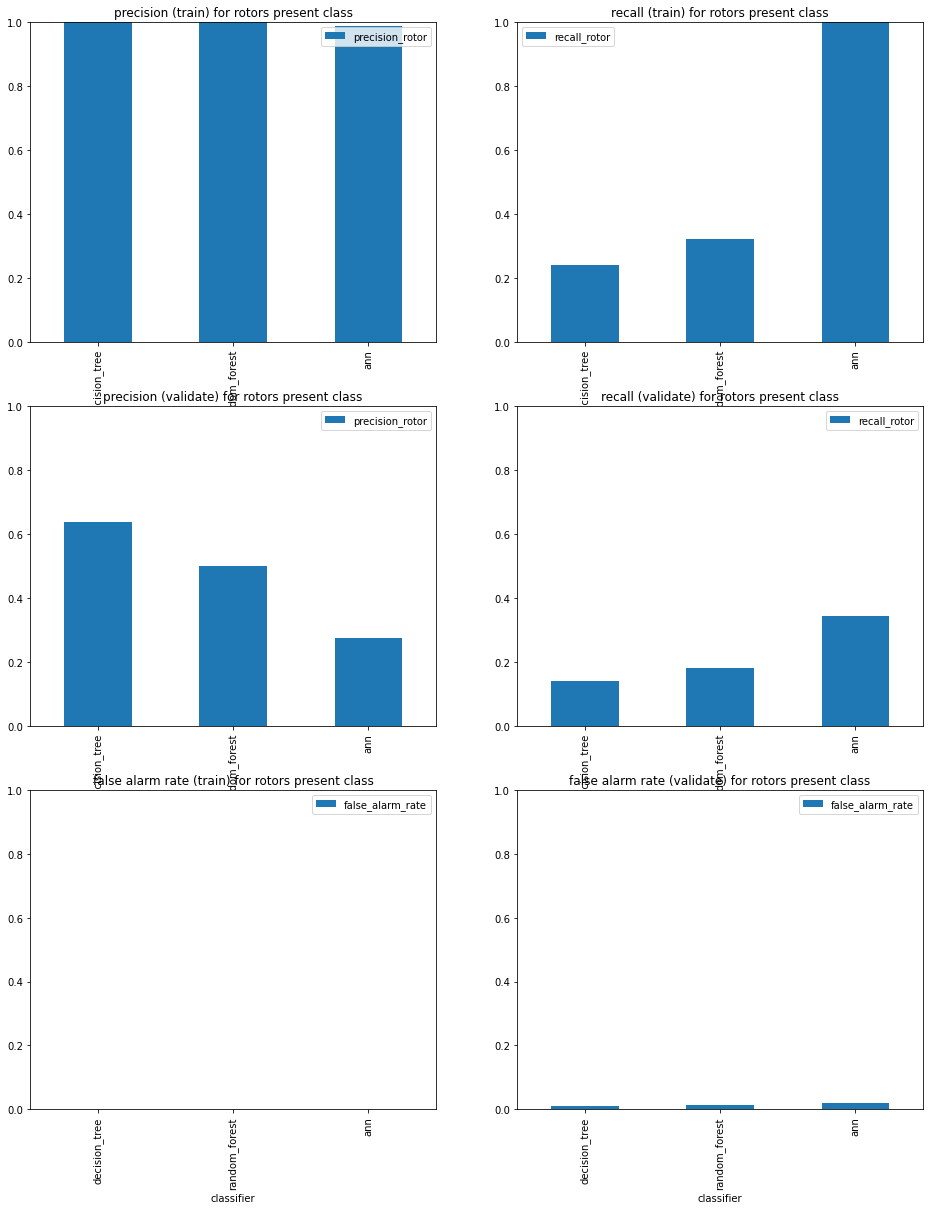

In [39]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
metrics_df_list['train'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
metrics_df_list['train'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
metrics_df_list['test'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
metrics_df_list['test'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
metrics_df_list['train'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
metrics_df_list['test'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [40]:
data_working['rotors_present'].value_counts()

False    15353
True       405
Name: rotors_present, dtype: int64

In [41]:
data_test['rotors_present'].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

Calculate SEDI metric.

In [42]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))

In [43]:
sedi_dict = {}
for set_name, (X1, y1) in train_test_dict.items():
    set_sedi_dict = {}
    for clf_name, clf1 in classifiers_dict.items():
        y_pred_raw = clf1.predict_proba(X1)[:,1]
        set_sedi_dict[clf_name] = opmet_metrics.calculate_sedi_suite(thresholds_list,
                                                                     y1, 
                                                                     y_pred_raw)
        
    sedi_dict[set_name] = set_sedi_dict     

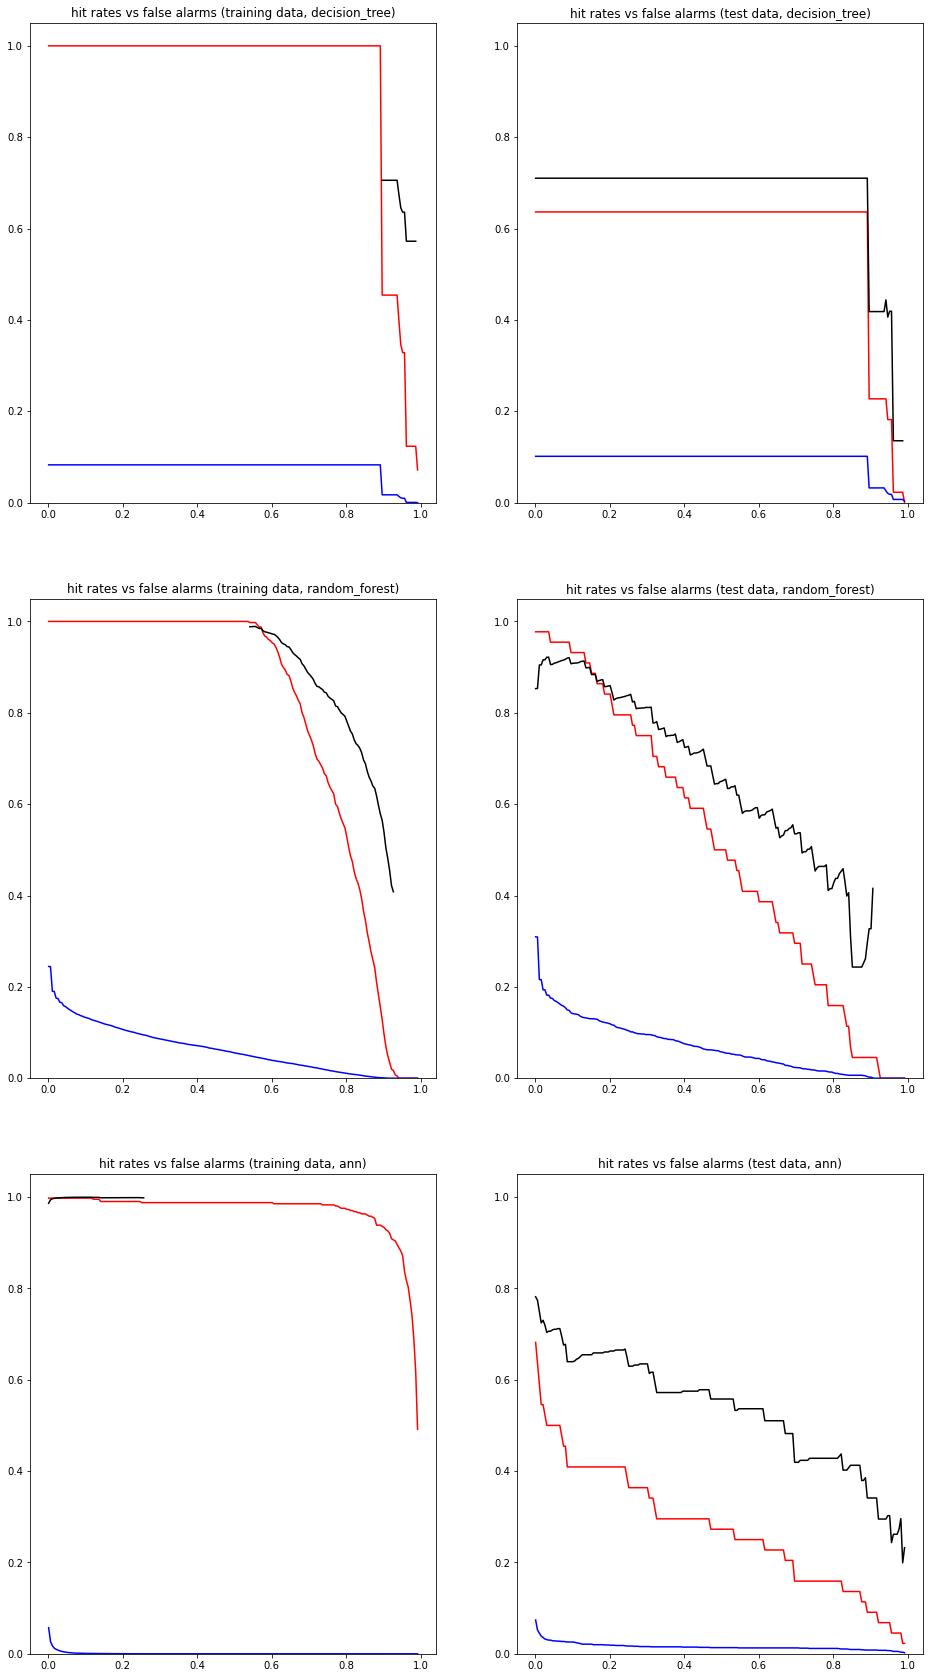

In [44]:
f1 = matplotlib.pyplot.figure(figsize=(16,10*len(classifiers_dict)))

plot_ix = 0
for clf_name, clf1 in classifiers_dict.items():
    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix + 1,title=f'hit rates vs false alarms (training data, {clf_name})')
    ax1.plot(thresholds_list, sedi_dict['train'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_dict['train'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_dict['train'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.05))

    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix+2,title=f'hit rates vs false alarms (test data, {clf_name})')
    ax1.plot(thresholds_list, sedi_dict['test'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_dict['test'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_dict['test'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.05))
    plot_ix += 2

In this sort of classification problem, there are 4 sorts of results:
* true postive(hits) - should be positive classification and is
* true negative - should be negative and is
* false negative (miss) - should be classified positive but is classified negative
* false positive (false alarm) - should be classified negative but is classified as positive by the algorithm

Given less than 100% accuracy, changing parameters can shift results between false negatives and false positive, depending on which is more damaging for how the prediction will be used. If we decide that predicting a rotor that doesn't happen is more costly, we would penalise false positives. If we decide that a rotor event happening when not forecast is more damaging, we penalise false negatives. Tis can be done by optimising for an F-score other F1. F1 balances tese out, but instead one use a different weighting in the F-score formula for one or the other.


### Resample the data 

Our yes/no classes for classification are very unbalanced, so we can try doing a naive resampling so we have equal representation fo the two classes in our sample set.

In [45]:
data_working_resampled = pandas.concat([
    data_working[data_working[target_feature_name] == True].sample(n=int(1e4), replace=True), 
    data_working[data_working[target_feature_name] == False].sample(n=int(1e4), replace=False),],
    ignore_index=True)

In [46]:
X_working_resampled = preproc_input(data_working_resampled, preproc_dict)
y_working_resampled = preproc_target(data_working_resampled, target_encoder)

In [47]:
train_test_res_dict = {
    'train':     (X_working_resampled, y_working_resampled),
    'test': (X_test, y_test),
}
train_test_res_tuples = list(train_test_res_dict.values())

In [48]:
%%time
classifiers_res_dict = {}                    
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class']()
    cv1 = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
    hpt1 = sklearn.model_selection.GridSearchCV(clf1, 
                                                clf_params['opts'],
                                                cv=cv1,
                                               )
    res1 = hpt1.fit(X_working, y_working)
    classifiers_res_dict[clf_name] = hpt1

decision_tree
random_forest
ann
CPU times: user 15min 27s, sys: 7.75 s, total: 15min 35s
Wall time: 5min 10s


In [49]:
metrics_res, metrics_res_df_list = opmet_metrics.calculate_metric_suite(
    classifiers_res_dict, 
    train_test_res_dict,
)

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

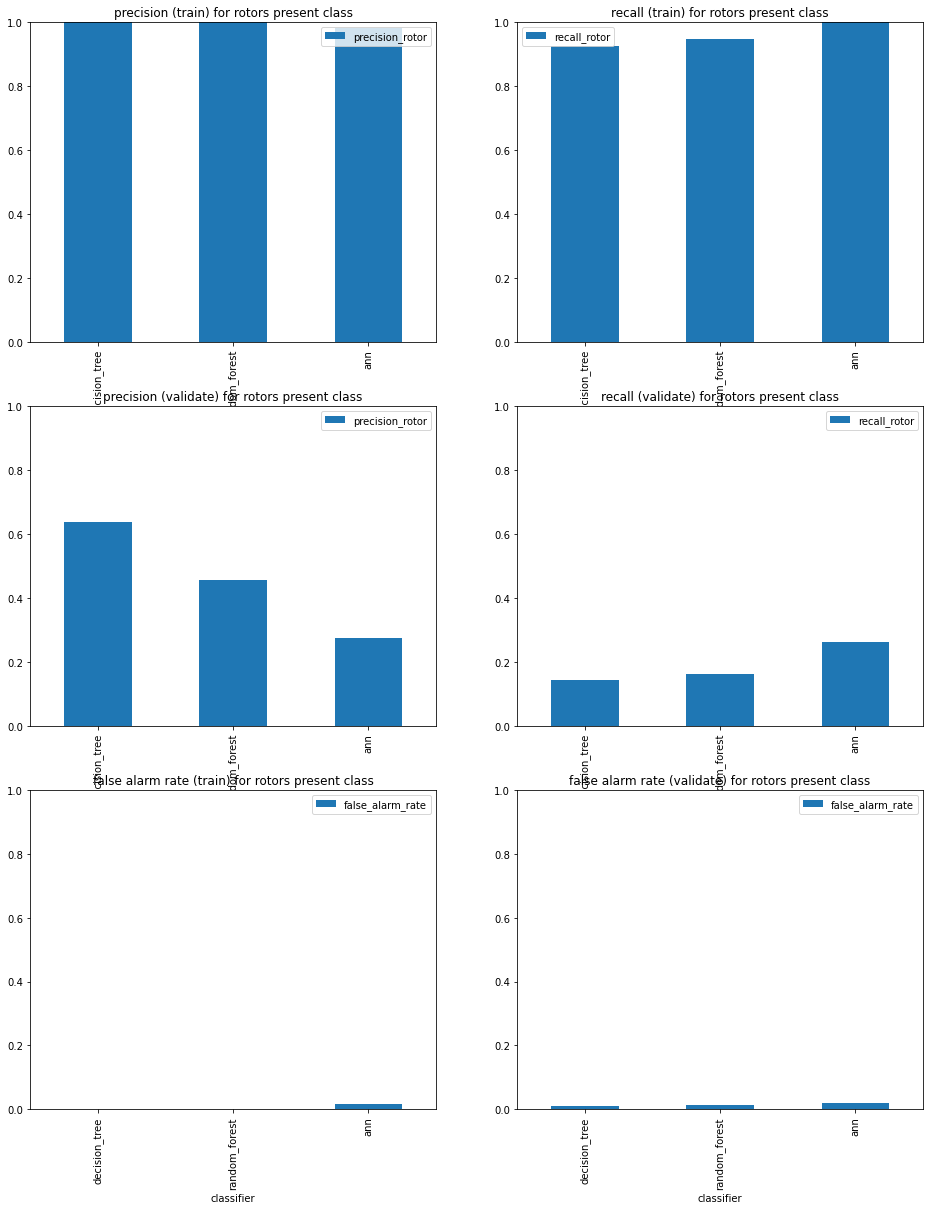

In [50]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
metrics_res_df_list['train'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
metrics_res_df_list['train'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
metrics_res_df_list['test'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
metrics_res_df_list['test'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
metrics_res_df_list['train'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
metrics_res_df_list['test'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [51]:
sedi_res_dict = {}
for set_name, (X1, y1) in train_test_dict.items():
    set_sedi_dict = {}
    for clf_name, clf1 in classifiers_dict.items():
        y_pred_raw = clf1.predict_proba(X1)[:, 1]
        set_sedi_dict[clf_name] = opmet_metrics.calculate_sedi_suite(thresholds_list,
                                                                     y1,
                                                                     y_pred_raw)
    sedi_res_dict[set_name] = set_sedi_dict

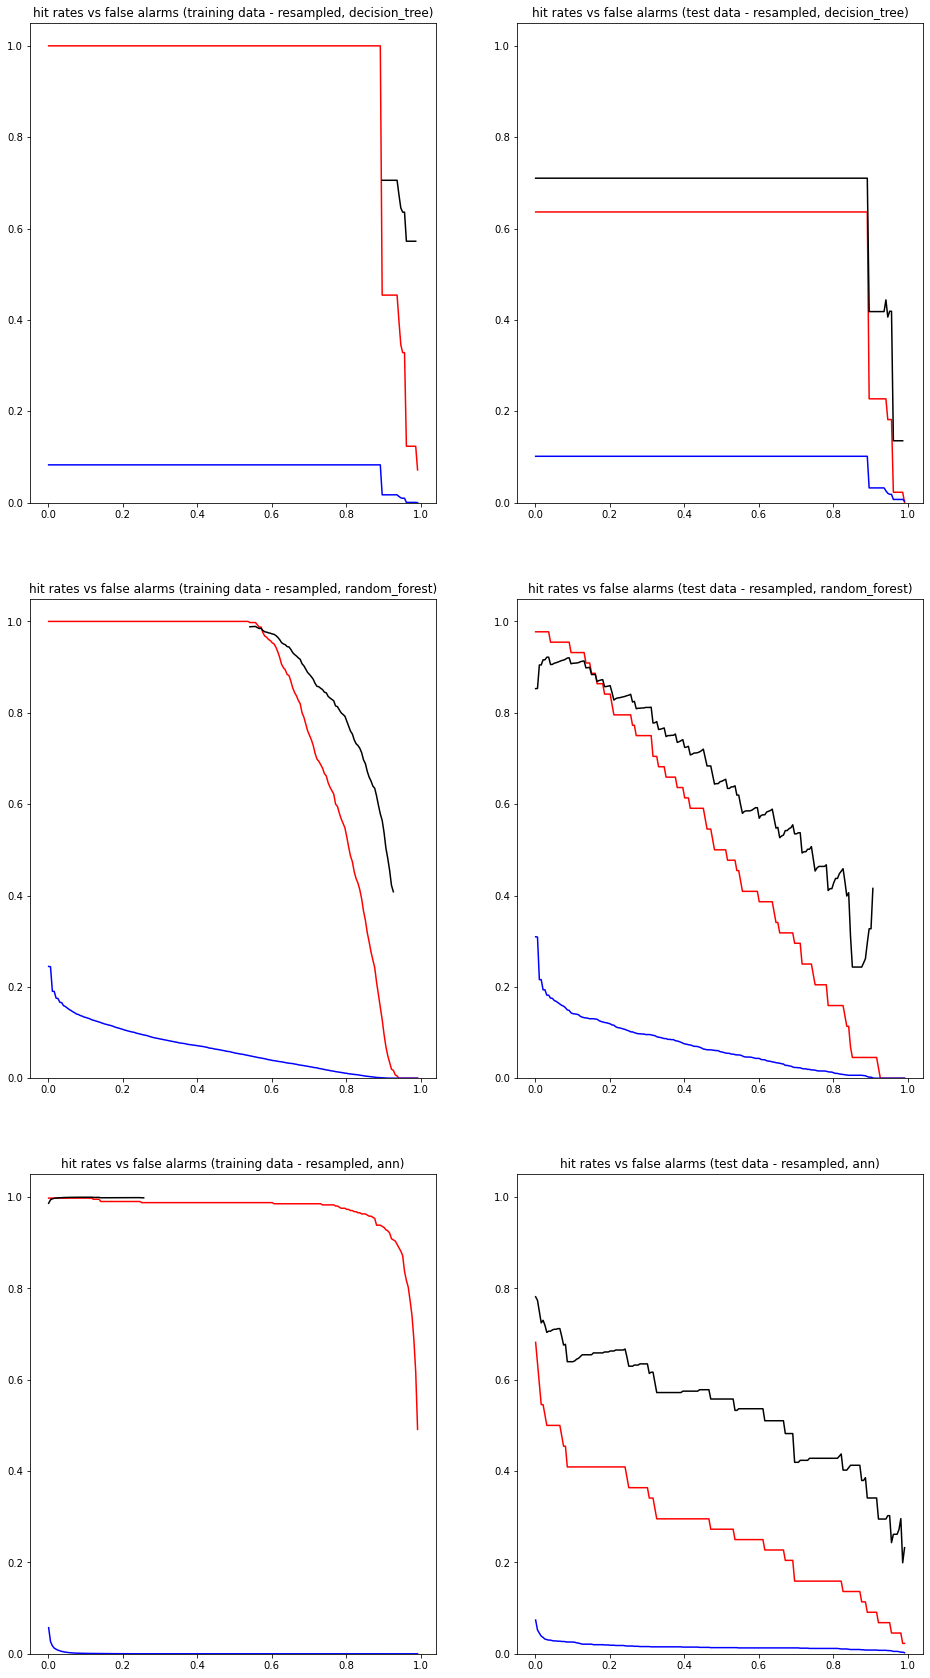

In [52]:
f1 = matplotlib.pyplot.figure('SEDI_hpt_resampled', figsize=(16,10*len(classifiers_res_dict)))
plot_ix = 0
for clf_name, clf1 in classifiers_res_dict.items():
    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix + 1,title=f'hit rates vs false alarms (training data - resampled, {clf_name})')
    ax1.plot(thresholds_list, sedi_res_dict['train'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_res_dict['train'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_res_dict['train'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.05))

    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix+2,title=f'hit rates vs false alarms (test data - resampled, {clf_name})')
    ax1.plot(thresholds_list, sedi_res_dict['test'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_res_dict['test'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_res_dict['test'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.05))
    plot_ix += 2